In [1]:
!git clone https://github.com/Sourajit-Maity/juvdv2-vdvwc.git

Cloning into 'juvdv2-vdvwc'...
remote: Enumerating objects: 5613, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 5613 (delta 0), reused 0 (delta 0), pack-reused 5571 (from 1)
Receiving objects: 100% (5613/5613), 538.71 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (5626/5626), done.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define image size and batch size
IMAGE_SIZE = 224
BATCH_SIZE = 32


In [ ]:
# Load and preprocess the dataset
# This is a placeholder for actual data loading logic
def load_data():
    # Implement data loading and preprocessing here
    # For example, use tf.data.Dataset or ImageDataGenerator for loading and augmenting data
    pass

# Advanced data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/juvdv2-vdvwc/Train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/juvdv2-vdvwc/Val',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
# Define the EfficientNetB0 model for classification as a base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


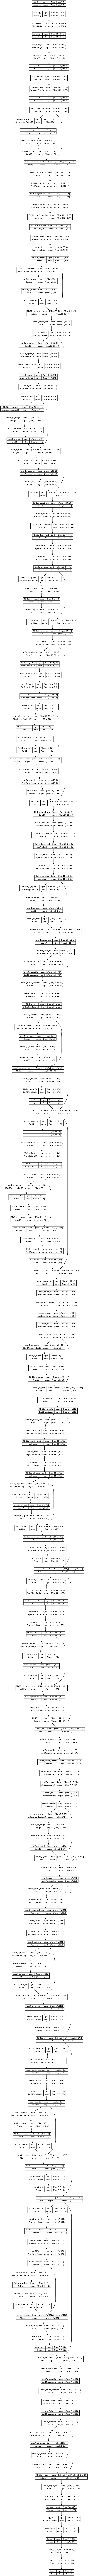

In [ ]:
# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define additional metrics
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

# Compile the model with additional metrics
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# Define custom F1 score callback
class F1ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        precision = logs.get('precision')
        recall = logs.get('recall')
        if precision is not None and recall is not None:
            f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
            logs['f1_score'] = f1_score
            print(f' — f1_score: {f1_score}')

# Create an instance of the F1 score callback
f1_score_callback = F1ScoreCallback()

# Define other callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Define learning rate scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)
# List of callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr, f1_score_callback]

# Compile the model
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)

# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)


Epoch 1/20
82/82 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9797
Epoch 1: val_loss improved from inf to 1.22676, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 — f1_score: 0.9253845906936672
82/82 [==============================] - 813s 10s/step - loss: 0.1875 - accuracy: 0.9254 - precision: 0.9254 - recall: 0.9254 - auc: 0.9797 - val_loss: 1.2268 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5881 - lr: 1.0000e-04 - f1_score: 0.9254
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970
Epoch 2: val_loss did not improve from 1.22676
 — f1_score: 0.9811537957870509
82/82 [==============================] - 753s 9s/step - loss: 0.0563 - accuracy: 0.9812 - precision: 0.9812 - recall: 0.9812 - auc: 0.9970 - val_loss: 1.5032 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5760 - lr: 1.0000e-04 - f1_score: 0.9812
Epoch 3/20
82/82 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9877 - precision: 0.9877 - recall: 0.9877 - auc: 0.9995
Epoch 3: val_loss improved from 1.2267

7/7 [==============================] - 2s 267ms/step - loss: 0.2955 - accuracy: 0.8950 - precision: 0.8950 - recall: 0.8950 - auc: 0.9632
Validation Accuracy: 89.50%
Validation Precision: 89.50%
Validation Recall: 89.50%
Validation AUC: 96.32%
7/7 [==============================] - 3s 284ms/step
              precision    recall  f1-score   support

      Rainny       0.46      0.41      0.43       100
       Sunny       0.47      0.52      0.49       100

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.47      0.46       200



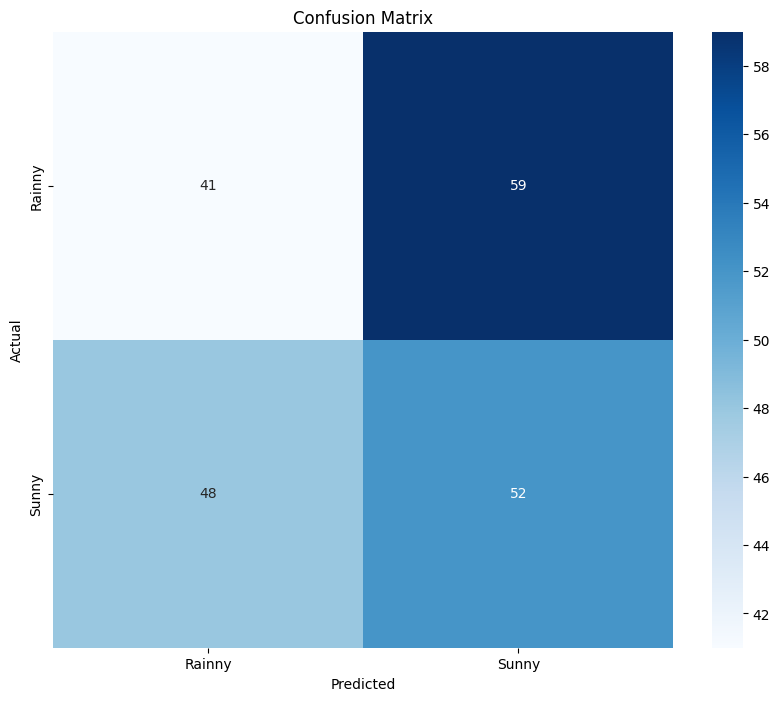

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, average_precision_score

# Evaluate the model
evaluation = model.evaluate(validation_generator)
loss = evaluation[0]
accuracy = evaluation[1]
precision_metric = evaluation[2]
recall_metric = evaluation[3]
auc_metric = evaluation[4]
print(f'Validation Accuracy: {accuracy*100:.2f}%')
print(f'Validation Precision: {precision_metric*100:.2f}%')
print(f'Validation Recall: {recall_metric*100:.2f}%')
print(f'Validation AUC: {auc_metric*100:.2f}%')

# Predict on validation data
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

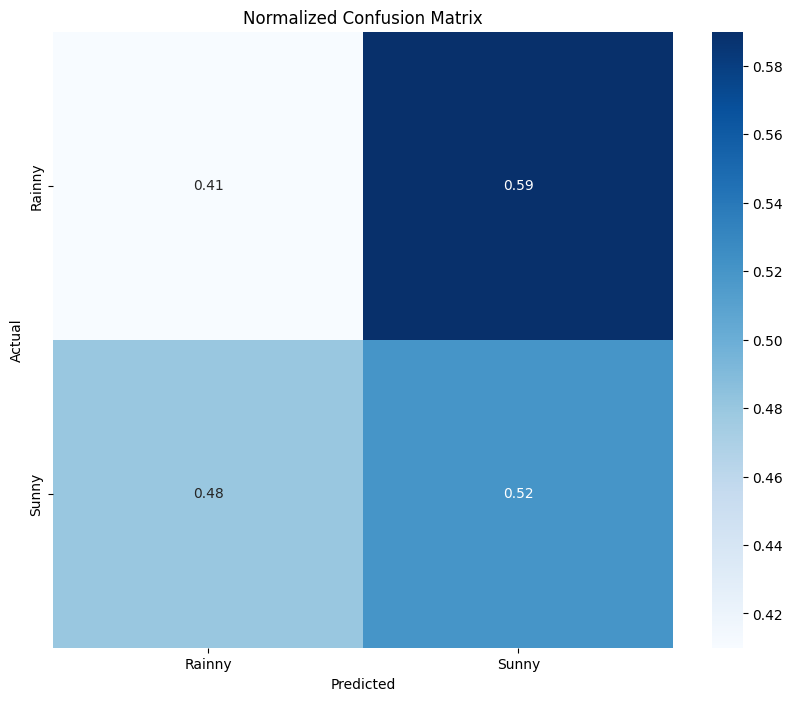

In [ ]:
# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Helper function to calculate mAP
def calculate_map(y_true, y_pred_proba, num_classes):
    average_precisions = []
    for class_id in range(num_classes):
        true_labels = (y_true == class_id).astype(int)
        pred_scores = y_pred_proba[:, class_id]
        average_precision = average_precision_score(true_labels, pred_scores)
        average_precisions.append(average_precision)
    mAP = np.mean(average_precisions)
    return mAP

# Calculate mAP
num_classes = len(validation_generator.class_indices)
map_score = calculate_map(y_true, y_pred, num_classes)

print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')
print(f'mAP: {map_score*100:.2f}%')


Precision: 46.46%
Recall: 46.50%
F1-Score: 46.34%
mAP: 51.35%


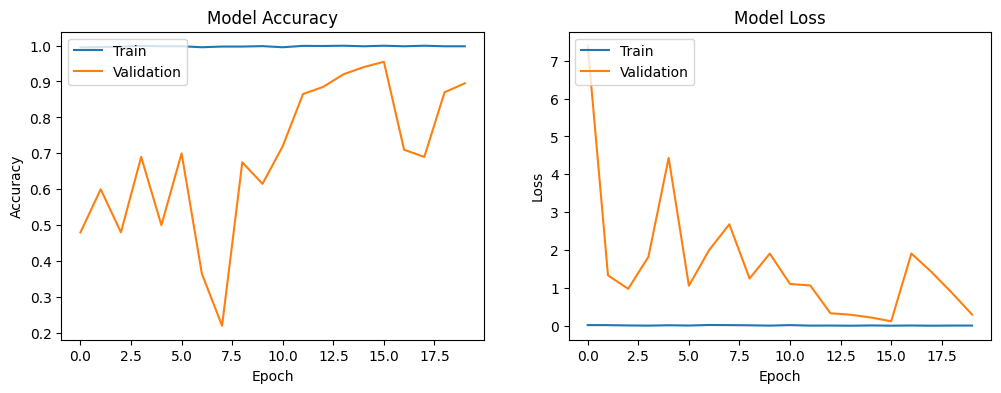

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


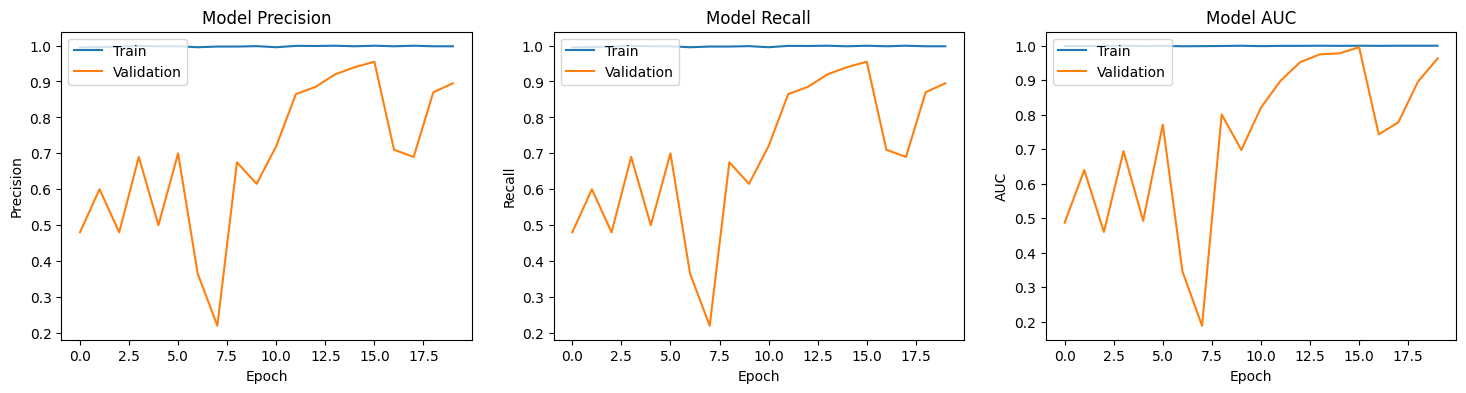

In [ ]:
# Additional plots for precision, recall, and AUC
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetB0

# Define global variables
IMAGE_SIZE = 224
NUM_CLASSES = 2  # Adjust this according to your number of classes

# Define EfficientNetB0 model with custom head
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Load the best saved model
model.load_weights('/content/best_model.h5')

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM overlay
def display_gradcam(img_path, heatmap, alpha=0.6):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Normalize heatmap to range [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap_colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend heatmap onto the image
    superimposed_img = cv2.addWeighted(img, alpha, heatmap_colormap, 1 - alpha, 0)

    # Display the superimposed image
    plt.figure(figsize=(8, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Path to the single image (adjust path accordingly)
img_path = '/content/juvdv2-vdvwc/Val/Rainny/Day/rainy day (651).jpg'

# Load and preprocess the single image
img_array = cv2.imread(img_path)
img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))  # Resize image
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize and expand dims

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(img_array, model, 'top_conv', pred_index=None)

# Display Grad-CAM overlay
display_gradcam(img_path, heatmap)


16705208/16705208 [==============================] - 0s 0us/step


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/content/best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import cv2
import tensorflow.keras.backend as K

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage
img_path = '/content/juvdv2-vdvwc/Val/Rainny/Day/rainy day (660).jpg'
img_array = np.expand_dims(cv2.resize(cv2.imread(img_path), (IMAGE_SIZE, IMAGE_SIZE)), axis=0) / 255.0
heatmap = get_gradcam_heatmap(img_array, model, 'top_conv')
display_gradcam(img_path, heatmap)
